# Анализ интернет-магазина компьютерных игр.

## Введение.

Данный проект направлен на проведение анализа для интернет-магазина компьютерных игр на основе открытых источников  исторических данных о продажах игр, оценки пользователей и экспертов, жанров и платформ. Цель проекта - выявление определяющих успешность игры закономерностей, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Проведения данного исследования будет базироваться на массиве данных, содержащем информацию о: названиях игр, платформах, годах выпуска, жанрах, продажах в Северной Америке, Европе, Японии и в других странах, оценки критиков, оценки пользователей, а так же рейтинг от организации ESRB (англ. Entertainment Software Rating Board), которая определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

В ходе проведения данного исследования планируется:

- Проведение предобработки данных с целью выявления ошибок, пропусков или дубликатов и их исправления.
- Исследовательский анализ данных, включающий определение количества игр, выпускаемых ежегодно, определение ориентировочного срока за который платформы появляются и исчезают, определение потенциально прибыльных платформ, определение наличия влияния отзывов пользователей и критиков на продажи, а так же определение наиболее успешных жанров.
- Составление портрета пользователя в Северной Америке, Европе, Японии путем определения наиболее популярных платформ и жанров в каждом регионе.
- Проверка ряда гипотез.

В заключении проекта будут сформированы основные выводы по резальтатам проведенного исследования, а так же описаны некоторые рекомендации.


## Загрузка данных.

In [1]:
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/datasets/games.csv')
    
data.head()    

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Промежуточный вывод:**
Согласно полученной информации о массиве данных в нем имеются пропуски и ошибки, требующие доработки. В частности, необходимо приведение к одному типу написания всех столбцов, некоторые столбцы имеют неверный тип данных, который требует исправления (столбец 'Year_of_Release' содержит только год выпуска, поэтому должен быть в типе данных int, столбец 'User_Score' содержит числовую оценку пользователей, поэтому должен быть в типе данных float64); также были выявлены пропуски в столбцах 'Year_of_Release', 'Critic_Score', 'User_Score', 'Rating', 'Name', 'Genre'.

Все возможные дайствия по доработке датафрейма будут проведены в следующем разделе.

## Предобработка данных.

Исправим названия всех столбцов, приведя их к единому стилю написания.

In [4]:
data = data.rename(columns={
    'Name':'name',
    'Platform':'platform',
    'Year_of_Release':'year_of_release',
    'Genre':'genre',
    'NA_sales':'na_sales',
    'EU_sales':'eu_sales',
    'JP_sales':'jp_sales',
    'Other_sales':'other_sales',
    'Critic_Score':'critic_score',
    'User_Score':'user_score',
    'Rating':'rating'
})

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Рассмотрим массив данных на наличие явных дубликатов.

In [5]:
data.duplicated().sum()

0

Явные дубликаты отсутствуют.

Проверим наличие неявных дубликатов, проведя поиск отдельно по столбцам 'name', 'platform', 'year_of_release'.

In [6]:
data_possible_dublicates = data [data.duplicated(['name', 'platform', 'year_of_release'])]

data_possible_dublicates

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14244,NaN,GEN,1993.0,NaN,0.0,0.00,0.03,0.0,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.0,83.0,5.5,E


Обнаружены два дубликата. Первый, в котором не указано значение name и genre, удалим, поскольку содержит значительное количество NaN в строке. 

Обработаем второй дубликат. Найдем задвоенные строки в датафрейме.

In [7]:
games_duplicated = data_possible_dublicates['name'].unique()
platforms_duplicated = data_possible_dublicates['platform'].unique()

data.query('(name in @games_duplicated) and (platform in @platforms_duplicated)')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


Для задвоенной игры Madden NFL 13 необходимо объединить данные лишь в столбце eu_sales. Перед удалением одной из строк, сохраним суммарное значение для этого столбца в переменной.

In [8]:
madden = data.query('(name in @games_duplicated) and (platform in @platforms_duplicated) and (year_of_release > 1993)')['eu_sales'].sum()

Удалим вторые строки из задвоенных и обновим индексы в массиве данных.

In [9]:
data = data.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep = 'first').reset_index(drop=True)

Найдем обновленный индекс для оставшейся строки. 

In [10]:
data.loc[(data['name'] == 'Madden NFL 13') & (data['platform'] == 'PS3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E


Присвоим необходимой ячейке сораненное значение.

In [11]:
data.loc[604, 'eu_sales'] = madden

Проверим, что данные в строке изменились.

In [12]:
data.loc[(data['name'] == 'Madden NFL 13') & (data['platform'] == 'PS3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.23,0.0,0.23,83.0,5.5,E


Проверим, что дубликат был удален из датафрейма.

In [13]:
data.query('(name in @games_duplicated) and (platform in @platforms_duplicated)')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.23,0.0,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.0,0.08,NaN,NaN,NaN


Дубликаты были удалены.

**Обработка типов данных и пропусков в столбцах.**

Столбец `year_of_release` содержит как пропуски, так и неверный тип данных, который требуется преобразовать в int, поскольку год может быть только целым числом, тип данных float64 ошибочен в данной ситуации.

Количество пропусков составляет менее 300 строк, что в процентном соотношении ко всему массиву данных незначительно, в связи с чем удалим данные строки, после чего преобразуем тип данных во всей колонке.

In [14]:
data = data.dropna(subset=['year_of_release'])

data['year_of_release'] = data['year_of_release'].astype('int')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       9838 non-null   object 
 10  rating           9767 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


Столбец `genre` содержит всего один пропуск, которые можно удалить из массива данных ввиду отсутствия какого-либо влияния данных двух строк на результат исследования.

In [15]:
data = data.dropna(subset=['genre'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       9838 non-null   object 
 10  rating           9767 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


Необходимо отметить, что после удаления данной строки, была также удалена строка с пропуском в столбце `name`.

Столбцы `user_score`, `critic_score` и `rating`.

Столбцы `user_score`, `critic_score` и `rating` содержат наибольшее количество пропусков. Данная информация может быть усугублена тем, что массив данных включает в том числе данные об играх созданных в том числе 30 лет назад, когда Интеренет не был глобально распространен, так же как и понятие "оценка пользователя" или "оценка критиков", вероятнее всего эти данные либо не существовали, либо не доступны для всех игр. Entertainment Software Rating Board, содержащийся в столбце `rating` был создан только в 1994 году, соответственно не мог быть использован для более ранних данных. Хочется отметить, что внедрение какого либо инструмента не может быть одномоментно, поэтому появление новой информации и более полное заполнение массива для вновь созданных игр проходило постепенно из года в год.

Выведем срез по датафрейму, содержащий данные только до 1997 года, для проверки указанной выше информации.

In [19]:
data_before_1997 = data.query('year_of_release < 1997')
data_before_1997

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
18,Super Mario World,SNES,1990,Platform,12.78,3.75,3.54,0.55,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15956,Strongest Tokyo University Shogi DS,DS,1985,Action,0.00,0.00,0.02,0.00,NaN,NaN,NaN
16206,Rock N' Roll Racing,SNES,1993,Racing,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16324,Victory Spike,PS,1996,Sports,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16466,Meru Purana,PS,1996,Strategy,0.00,0.00,0.01,0.00,NaN,NaN,NaN


In [20]:
data_before_1997.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968 entries, 1 to 16664
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             968 non-null    object 
 1   platform         968 non-null    object 
 2   year_of_release  968 non-null    int64  
 3   genre            968 non-null    object 
 4   na_sales         968 non-null    float64
 5   eu_sales         968 non-null    float64
 6   jp_sales         968 non-null    float64
 7   other_sales      968 non-null    float64
 8   critic_score     12 non-null     float64
 9   user_score       12 non-null     object 
 10  rating           12 non-null     object 
dtypes: float64(5), int64(1), object(5)
memory usage: 90.8+ KB


Как видно из указанной выше информации, только 0,1% данных имеет информацию в данных столбцах. 

Но необходимо так же отметить, что пропуски данной информации содержатся и в более поздних годах, например 2016, что может быть связано низкой популярностью игр или их низким распространением среди пользователей, в связи с чем они не были оценены, либо ошибкой в сборе данных.

Рассмотри пропуски в каждом из данных трех столбцов отдельно.

Столбец `user_score`

Рассмотрим уникальные значения в данном столбце:

In [21]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В данной колонке имеются значения tbd (eng. to be determined - будет определено), т.е. значения, которые предполагались к определению. 

Ввиду отсутствия данных для заполнения, либо каких-либо взаимосвязей, заполним пропуски и значения tbd значением -1 для упрощения дальнейшей сортировки.

После этого, приведем данные в этой колонке к типу float.

In [22]:
data.loc[(data['user_score']== 'tbd'), 'user_score'] = -1
data.loc[(data['user_score'].isna()), 'user_score'] = -1

data['user_score'] = data['user_score'].astype('float')

data['user_score'].unique()

array([ 8. , -1. ,  8.3,  8.5,  6.6,  8.4,  8.6,  7.7,  6.3,  7.4,  8.2,
        9. ,  7.9,  8.1,  8.7,  7.1,  3.4,  5.3,  4.8,  3.2,  8.9,  6.4,
        7.8,  7.5,  2.6,  7.2,  9.2,  7. ,  7.3,  4.3,  7.6,  5.7,  5. ,
        9.1,  6.5,  8.8,  6.9,  9.4,  6.8,  6.1,  6.7,  5.4,  4. ,  4.9,
        4.5,  9.3,  6.2,  4.2,  6. ,  3.7,  4.1,  5.8,  5.6,  5.5,  4.4,
        4.6,  5.9,  3.9,  3.1,  2.9,  5.2,  3.3,  4.7,  5.1,  3.5,  2.5,
        1.9,  3. ,  2.7,  2.2,  2. ,  9.5,  2.1,  3.6,  2.8,  1.8,  3.8,
        0. ,  1.6,  9.6,  2.4,  1.7,  1.1,  0.3,  1.5,  0.7,  1.2,  2.3,
        0.5,  1.3,  0.2,  0.6,  1.4,  0.9,  1. ,  9.7])

Предположим наличие зависимости рейтинга пользователей и общей выручки от продаж, поскольку можно предположить, что продукты с высоким рейтингом продаются лучше. 
Для этого добавим в массив данных столбец с суммарной выручкой по всем регионам, после чего составим сводную таблицу и рассчитаем минимальные и максимальные значения продаж для каждого рейтинга.

In [23]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

data['user_score_int'] = round(data['user_score'], 0)

data.pivot_table(index='user_score_int', values='total_sales', aggfunc=['min', 'max', 'median'])

,min,max,median
,total_sales,total_sales,total_sales
user_score_int,,,
-1.0,0.00,40.24,0.110
0.0,0.04,0.72,0.110
1.0,0.01,0.36,0.080
2.0,0.01,1.71,0.130
3.0,0.01,14.73,0.160
4.0,0.01,8.58,0.180
5.0,0.01,13.79,0.220
6.0,0.01,21.82,0.240


Прослеживается некоторая зависимость медианного общего количества продаж от рейтинга пользователей, но в то же время для каждого рейтинга есть продукты с продажами, близкими к нулю, и продукты с высокими продажами (даже для относительно низкого рейтинга 3.0), медианные значения так же близки к нулю, поэтому сделаем вывод, что несмотря на наличие такой зависимости, оставшиеся пропущенные значения восстановить невозможно, оставим их пропущенными. 

Удалим столбец с округленными значениями рейтинга пользователей. 

Столбец с `total_sales` будет оставлен, поскольку потребуется для проведения дальнейших вычислений и его наличие требуется в соответствии с заданием к проекту.

In [24]:
data.drop(labels='user_score_int', axis=1, inplace=True)

Столбец `critic_score`

Учитывая отсутствие каких либо взаимосвязей, которые могли бы использоваться для заполнения пропусков данном столбце, заменим их на -1, для обеспечения удобной сортировки в дальнейшем.

In [25]:
data.loc[(data['critic_score'].isna()), 'critic_score'] = -1

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  float64
 10  rating           9767 non-null   object 
 11  total_sales      16443 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


Столбец `rating`

Рассмотрим наличие зависимости между рейтингом (рейтинг от организации ESRB (англ. Entertainment Software Rating Board)) и жанром, предположив, что некоторые жанры могут в большей степени подходить определенным возрастным категориям.

In [26]:
ratings = data.pivot_table(index=['genre', 'rating'], values='name', aggfunc = 'count')
ratings = ratings.reset_index()

ratings.head(15)
    

,genre,rating,name
0,Action,AO,1
1,Action,E,410
2,Action,E10+,468
3,Action,EC,1
4,Action,M,596
5,Action,T,670
6,Adventure,E,159
7,Adventure,E10+,67
8,Adventure,EC,2
9,Adventure,M,98


В соответствии с полученной таблицей, каждый жанр представлен в различных рейтингах, что не позволяет учитывать данную информацию для заполнения пропусков. в связи с этим, заменим пропущенные значения на 'no_rating'.

In [28]:
data.loc[(data['rating'].isna()), 'rating'] = 'no_rating'
   
data.head(15)    

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,no_rating,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,no_rating,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,-1.0,-1.0,no_rating,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-1.0,-1.0,no_rating,28.31


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
 11  total_sales      16443 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


**Вывод по разделу.**

В данном разделе были выполнены следующие действия:
1. Названия были приведены к единому типу написания без использования прописных букв;
2. Столбцы 'Year_of_Release', 'User_Score' были приведены к правильному типу данных.
3. Удалены некоторые строки с отсутствием информации в столбцфч 'Year_of_Release', 'Genre' и 'Name' (составляющие незначительный процент от всего массива данных)
4. Были полностью заполнены все пропуски в столбце 'Rating', а также частично в столбцах 'Critic_Score', 'User_Score' поскольку заполнение их полностью не представляется возможным.
5. В массив данных был добавлен столбец `total_sales` с суммарной выручкой по всем регионам.

Таким образом, можно сделать вывод, что имеющийся массив данных был подготовлен к дальнейшему исследованию насколько это было возможно.

In [30]:
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
 11  total_sales      16443 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

## Исследовательский анализ данных.

### Количество игр, выпускаемых ежегодно.

Определим количество игр, которые выпускались ещегодно согласно массиву данных.

In [31]:
data_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
data_year = data_year.reset_index().sort_values(by='name')

Text(0, 0.5, 'Количество выпущенных игр')

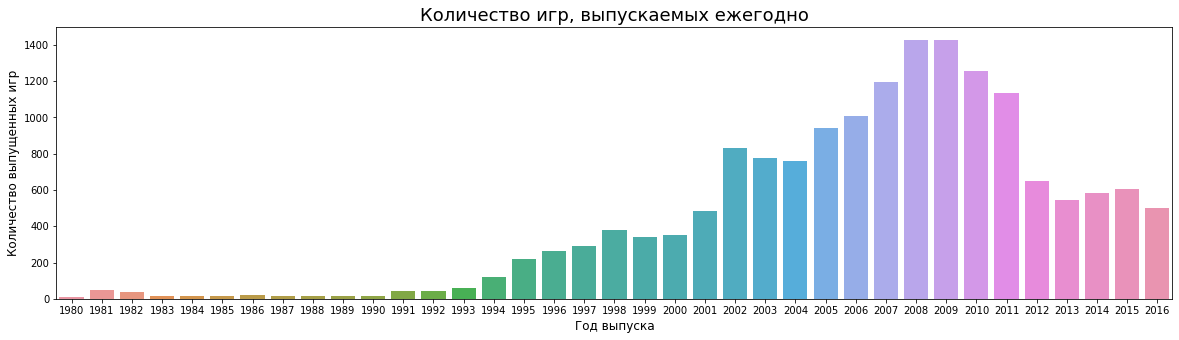

In [32]:
plt.figure(figsize=(20, 5))
data_year_diagram = sns.barplot(x='year_of_release', y='name', data=data_year)


data_year_diagram.set_title('Количество игр, выпускаемых ежегодно', fontsize=18)
data_year_diagram.set_xlabel('Год выпуска', fontsize=12)
data_year_diagram.set_ylabel('Количество выпущенных игр', fontsize=12)

Согласно полученной диаграмме, первые игры, учтенные в имеющемся массиве данных, были созданы в 1980, но количество выпускаемых игр было незначительно до 1993 года, после чего наблюдался значительный рост количества, создаваемого ежегодно. Максимальное количество игр было выпущено в 2008 и 2009 годах, после чего интенсивность данного процесса пошла на спад. В связи с этим, можно сказать, что большая часть данных ранних периодов не важна в рассчетах, особенно учатывая, что в соответствующих данных пропущены практически все значения в столбцах 'critic_score', 'user_score', 'rating' ввиду отсутствия систем оценки в то время. Также объемы продаж в данные годы были незначительны ввиду низкого уровня распространения персональных компьютеров и сети Интернет.

In [33]:
data['year_of_release'].describe()

count    16443.000000
mean      2006.485921
std          5.875546
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

Согласно данному описанию характерных значений для столбца 'year_of_release', наибольшее количество выпущенных игр было создано в период с 2003 до 2010 года.

### Продажи по платформам.

Определим пять платформ, имеющих максимальные суммарные продажи.

In [34]:
data_platforms = data.pivot_table(index='platform', values='total_sales', aggfunc='sum')

data_platforms = data_platforms.sort_values(by='total_sales', ascending=False).reset_index()

data_platforms.head()

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78


Text(0, 0.5, 'Продажи (миллионы проданных копий)')

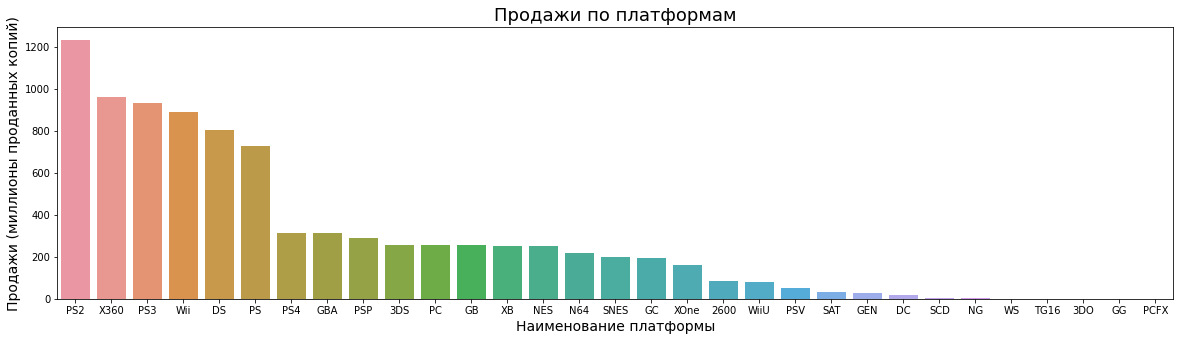

In [35]:
plt.figure(figsize=(20, 5))
data_platforms_diagram = sns.barplot(x='platform', y='total_sales', data=data_platforms)


data_platforms_diagram.set_title('Продажи по платформам', fontsize=18)
data_platforms_diagram.set_xlabel('Наименование платформы', fontsize=14)
data_platforms_diagram.set_ylabel('Продажи (миллионы проданных копий)', fontsize=14)

Построим распределение по годам для каждой платформы и определим за какой характерный срок появляются и исчезают платформы.

In [36]:
best_platforms = data_platforms.loc[0:4, 'platform'] # Пять наиболее успешных платформ

best_platforms

0     PS2
1    X360
2     PS3
3     Wii
4      DS
Name: platform, dtype: object

Text(0, 0.5, 'Продажи (миллионы проданных копий)')

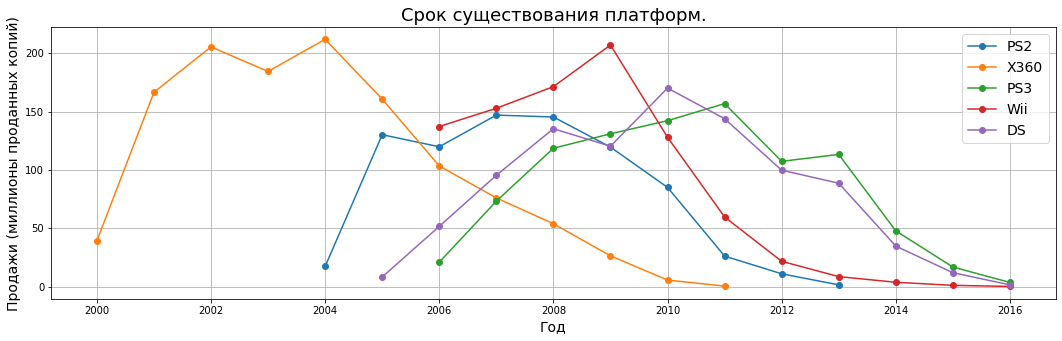

In [37]:
fig, ax = plt.subplots()

data_best_platforms = data.query('(platform in @best_platforms) and (year_of_release >= 2000)')

for platform, life_expectancy in data_best_platforms.groupby('platform'):
    (life_expectancy.
     pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').
     plot(ax=ax, style='o-', figsize=(18,5), grid=True, label=platform)
    )

plt.legend(best_platforms, fontsize=14)
plt.title('Срок существования платформ.', fontsize=18)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Продажи (миллионы проданных копий)', fontsize=14)

Согласно полученным графикам и произведенным расчетам, медианный срок существования платформ составляет 7 лет. Необходимо отметить, что все платформы, выявленные как наиболее успешные в соответствии с наибольшим количеством продаж копий игр, завершили свой срок жизни и исчезли или практически исчезли к 2016 году. Ни одна платформа, находящаяся в 2016 году в стадии роста или пика не была определена как успешная ввиду меньших объемов продаж. Данное заключение соответствует выявленному в п.4.1 нисходящему процессу в целом по рынку. На представленной в данном пункте диаграмме было выявленно, что продажи игр падают практически ежегодно начиная с 2009 года. Данный эффект может быть связан с имеющейся тенденцией с завершением срока жизни лидирующих платформ, а также с возможным изменением предпочтений пользователей или их переориентацией на другие типы развлечений, например, социальные сети.

In [38]:
temp = data.copy() 
time_life = temp.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1 # в срок жизни платформы, должны входить границы диапазона, 
                                                            # поэтому +1
time_life['life'].median()

7.0

Учитывая особенности рынка видеоигр и их динамичное развитие, выберем для дальнейшей реализации проекта и прогнозирования данные за последние 3 года как наиболее актуальные для посттроекния существующих трендов в индустрии.

In [39]:
data_useful = data.query('year_of_release > 2013')

Рассмотрим тенденции в продажах для каждой из платформ, представленной в данный период времени.

In [40]:
data_useful_sum = (data_useful.
                   pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc='sum').
                   reset_index()
                  )
data_useful_sum 

,platform,year_of_release,total_sales
0,3DS,2014,43.76
1,3DS,2015,27.78
2,3DS,2016,15.14
3,PC,2014,13.28
4,PC,2015,8.52
5,PC,2016,5.25
6,PS3,2014,47.76
7,PS3,2015,16.82
8,PS3,2016,3.60
9,PS4,2014,100.00


Рассмотрим полученные данные в графическом виде.

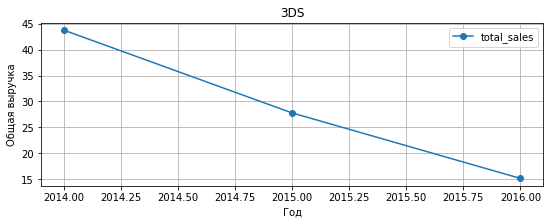

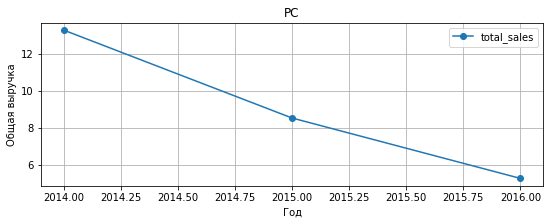

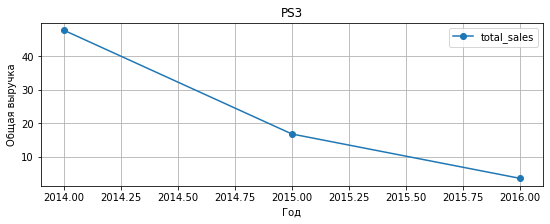

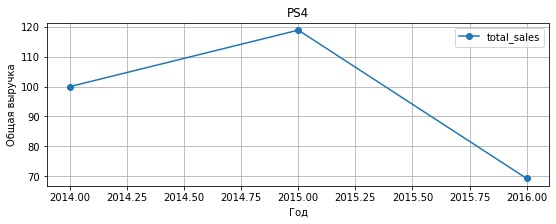

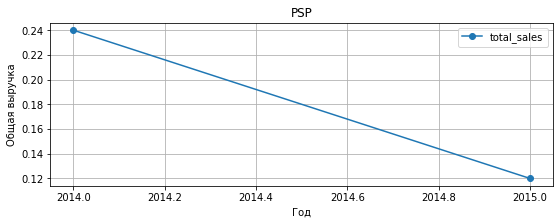

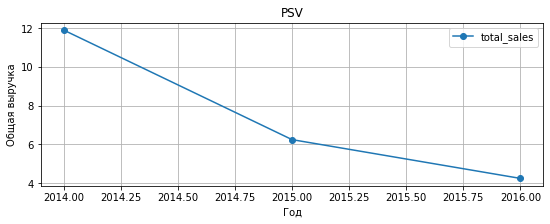

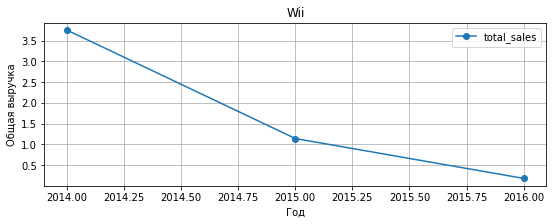

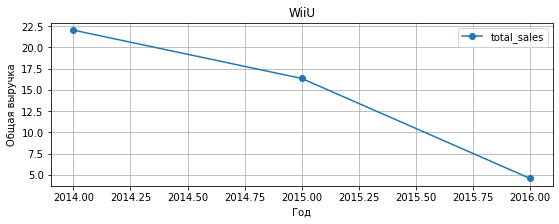

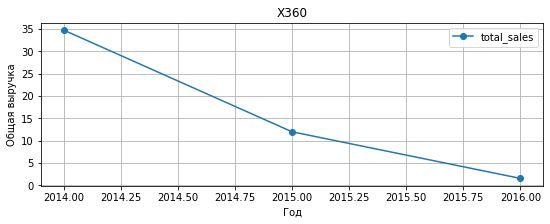

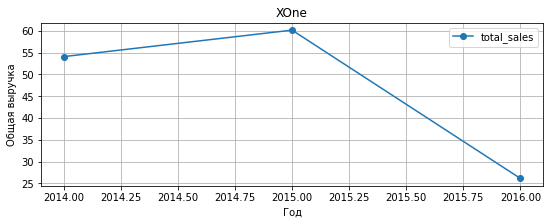

In [41]:
for platform, year in data_useful_sum.groupby('platform'):
    year.plot(x='year_of_release', y='total_sales', style='o-', grid=True, figsize=(9,3), title=platform)
    
    plt.xlabel('Год')
    plt.ylabel('Общая выручка')
  

Согласно полученным графикам, все существующие платформы находятся в нисходящем этапе, растущих платформ не выявлено. Перспективными для учета в 2017 году можно считать платформы, которые имеют наибольшие продажи, а значит не находятся в завершении своего жизненного цикла. Такими платформами могут быть:

Самые перспективные платформы:
- PS4 (69,25 млн.проданных копий в 2016 году)
- XOne (26,15 млн.проданных копий в 2016 году)

### Глобальные продажи игр в разбивке по платформам.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам для выбранного периода времени после 2013 года.

Text(0, 0.5, 'Продажи (миллионы проданных копий)')

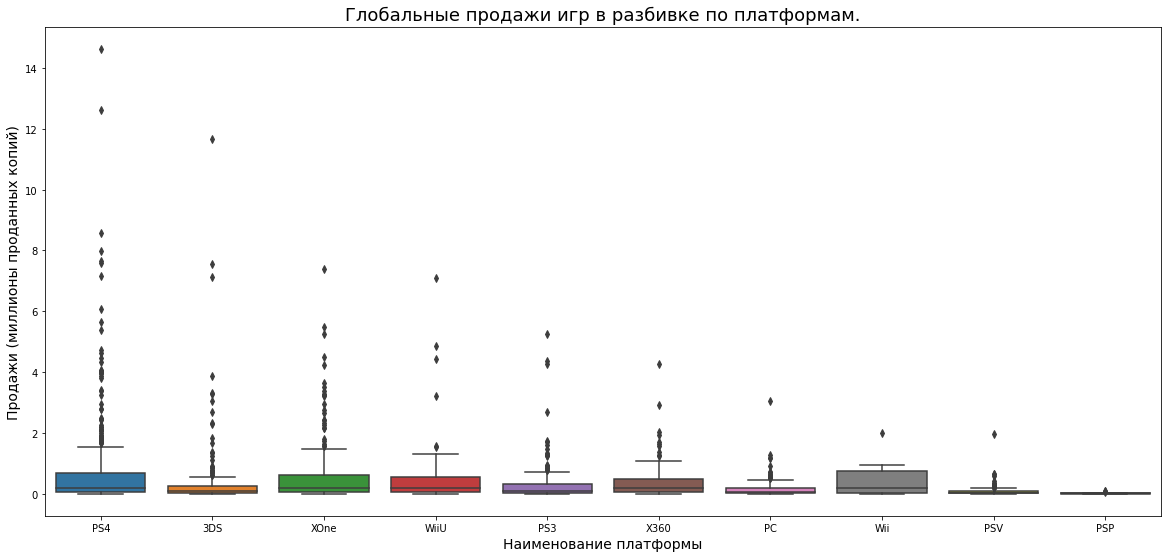

In [42]:
plt.figure(figsize=(20, 9))

sns.boxplot(x = 'platform', y = 'total_sales', data = data_useful)

plt.title('Глобальные продажи игр в разбивке по платформам.', fontsize=18)
plt.xlabel('Наименование платформы', fontsize=14)
plt.ylabel('Продажи (миллионы проданных копий)', fontsize=14)

Построим данный график более наглядно, без учета существенных выбросов у ряда платформ.

Text(0, 0.5, 'Продажи (миллионы проданных копий)')

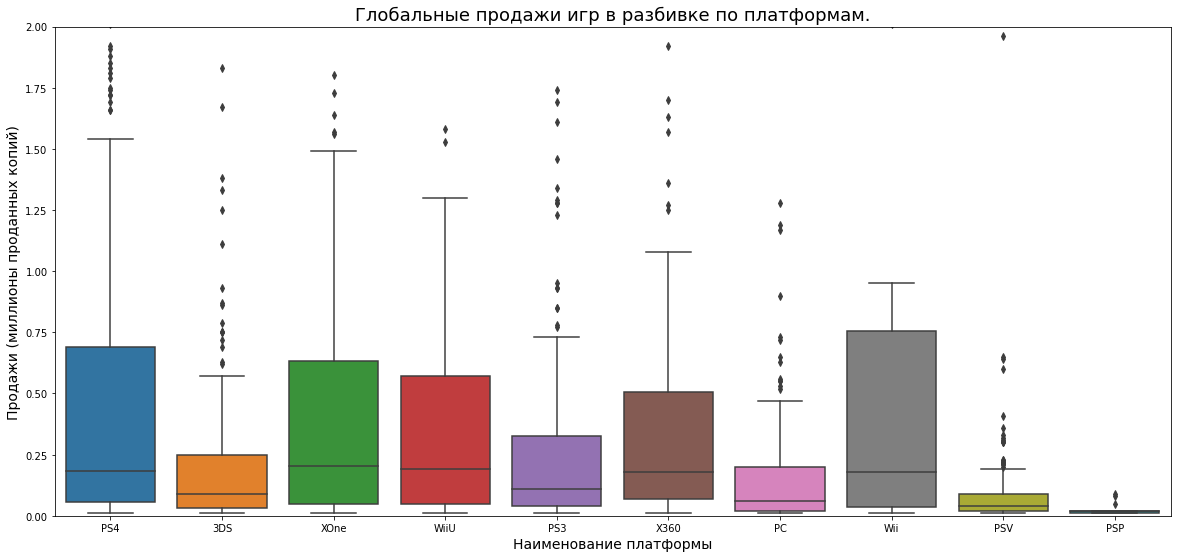

In [43]:
plt.figure(figsize=(20, 9))

sns.boxplot(x = 'platform', y = 'total_sales', data = data_useful)

plt.ylim(0, 2)
plt.title('Глобальные продажи игр в разбивке по платформам.', fontsize=18)
plt.xlabel('Наименование платформы', fontsize=14)
plt.ylabel('Продажи (миллионы проданных копий)', fontsize=14)

Как видно из полученных графиков, некоторые платформы имели лишь единичные продажи (PSP). Каждая платформа из остальных имеет достаточно успешные игры, которые имели высокие уровни продаж, отличающиеся от основного объема игр, но это единицы, воспринимаемые как выбросы, поскольку продажи основного объема игр значительно ниже, в связи с этим все ящики приближены к нулю, их медианное значение не превышает 0,25 млн проданных копий для каждой платформы. Данная тенденция была так же выявлена в п.3 данного исследования при предобработке данных.
Платформы, имеющие наибольшее медианное значение продаж, приближающееся к 0,25 млн копий: PS4, XOne, WiiU, X360, Wii. Платформы PS4 и Wii имели наибольший межквартильный размах для продаваемых игр, что может говорить о наличии многих успешных играх, в том числе имеющих значительное количество продаж и не являющихся выбросами.

### Влияние на продажи отзывов пользователей и критиков.

Поскольку значительное количество пропусков в имеющемся массиве данных обработать не представляется возможным, для более точной оценки влияния отзывов на продажи, будем учитывать при анализе данные, заполненные полностью в столбцах critic_score и user_score. В связи с этим сделаем срез данных, который будет отсекать незаполненную честь и рассмотрим взияние отзывов данных двух категории для каждой платформы.

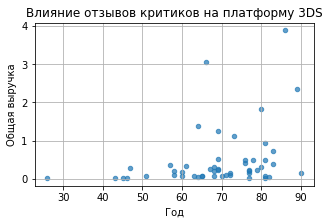

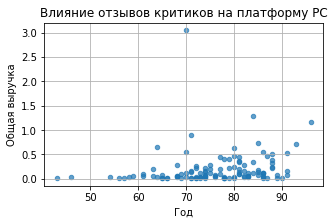

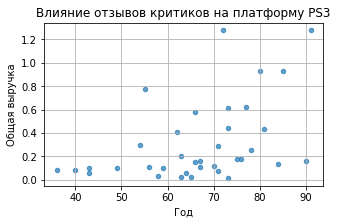

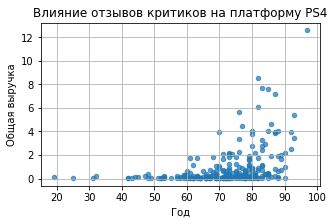

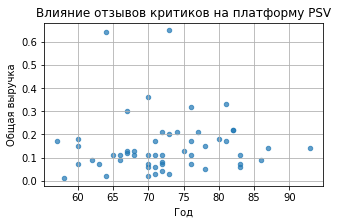

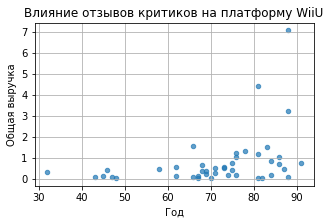

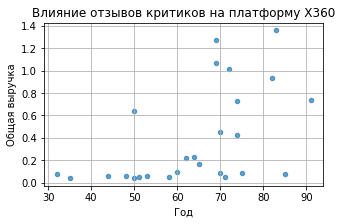

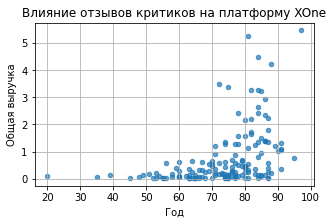

In [45]:
data_useful_critic = data_useful.query('critic_score >= 0')

for platform, influence in data_useful_critic.groupby('platform'):
    title1 = 'Влияние отзывов критиков на платформу ' + platform
    influence.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.7, grid=True, figsize=(5,3), title=title1)    
    
    plt.xlabel('Год')
    plt.ylabel('Общая выручка')

In [46]:
print ('Коэффициент корреляции (отзывы критиков) для платформ')

for platform, influence in data_useful_critic.groupby('platform'):
    print (f'{platform}', influence['critic_score'].corr(influence['total_sales']))

Коэффициент корреляции (отзывы критиков) для платформ
3DS 0.314117492869051
PC 0.17463413769350036
PS3 0.44657460493190704
PS4 0.40266141068104083
PSV 0.04266490657009526
WiiU 0.370201412480884
X360 0.5257228356581523
XOne 0.42867694370333226


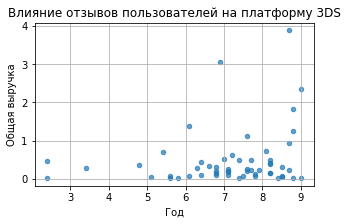

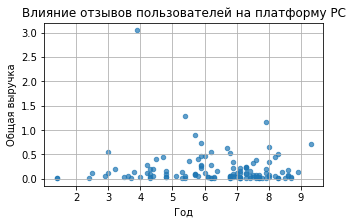

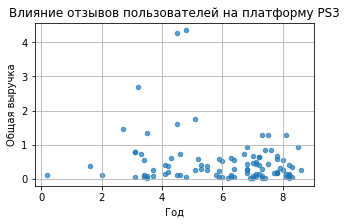

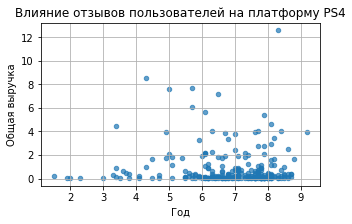

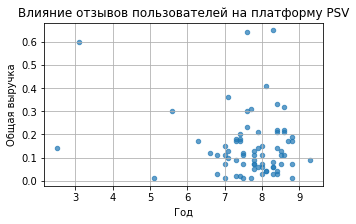

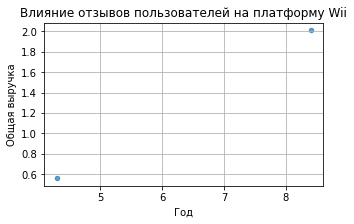

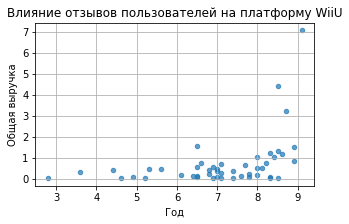

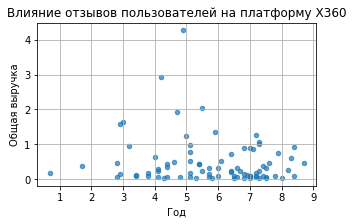

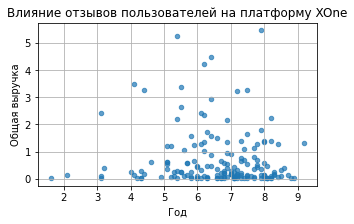

In [47]:
data_useful_user = data_useful.query('user_score >= 0')

for platform, influence in data_useful_user.groupby('platform'):
    title2 = 'Влияние отзывов пользователей на платформу ' + platform
    influence.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.7, grid=True, figsize=(5,3), title=title2)
    
    plt.xlabel('Год')
    plt.ylabel('Общая выручка')

In [48]:
print ('Коэффициент корреляции (отзывы пользователей) для платформ')

for platform, influence in data_useful_user.groupby('platform'):
    print (f'{platform}', influence['user_score'].corr(influence['total_sales']))

Коэффициент корреляции (отзывы пользователей) для платформ
3DS 0.2151932718527028
PC -0.07159665703472451
PS3 -0.16676141347662118
PS4 -0.040131589472697356
PSV -0.16845504978064446
Wii 1.0
WiiU 0.40792645792170773
X360 -0.138444570945665
XOne -0.0703839280647581


Расчет по Платформе 3DS


user_score     0.215193
total_sales    1.000000
Name: total_sales, dtype: float64

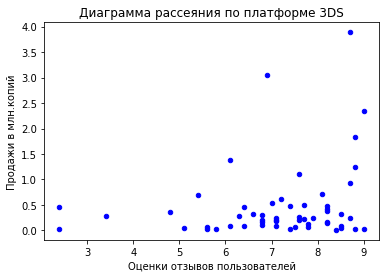

critic_score    0.314117
total_sales     1.000000
Name: total_sales, dtype: float64

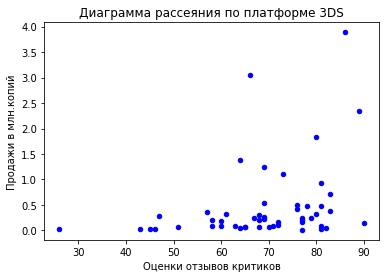

Расчет по Платформе PC


user_score    -0.071597
total_sales    1.000000
Name: total_sales, dtype: float64

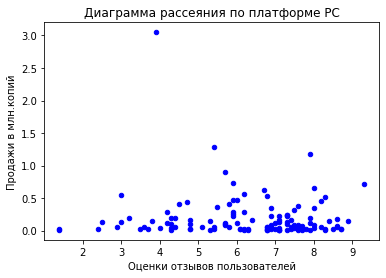

critic_score    0.174634
total_sales     1.000000
Name: total_sales, dtype: float64

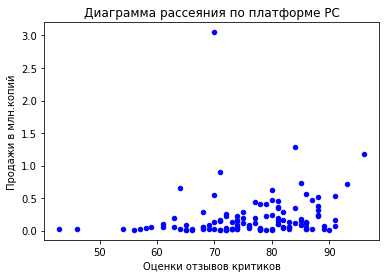

Расчет по Платформе PS3


user_score    -0.166761
total_sales    1.000000
Name: total_sales, dtype: float64

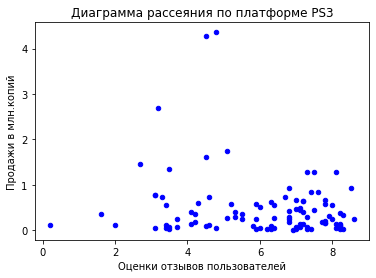

critic_score    0.446575
total_sales     1.000000
Name: total_sales, dtype: float64

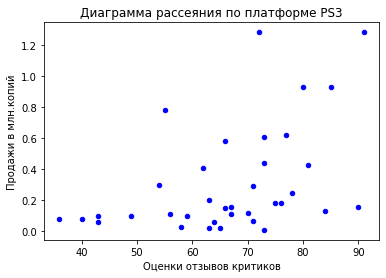

Расчет по Платформе PS4


user_score    -0.040132
total_sales    1.000000
Name: total_sales, dtype: float64

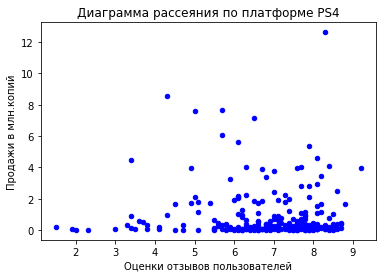

critic_score    0.402661
total_sales     1.000000
Name: total_sales, dtype: float64

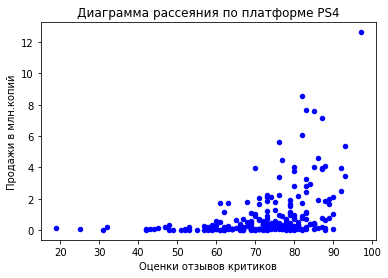

Расчет по Платформе PSP
Для платформы PSP не хватает данных для построения диаграммы и расчета корреляции отзывов пользователей
Для платформы PSP не хватает данных для построения диаграммы и расчета корреляции отзывов критиков
Расчет по Платформе PSV


user_score    -0.168455
total_sales    1.000000
Name: total_sales, dtype: float64

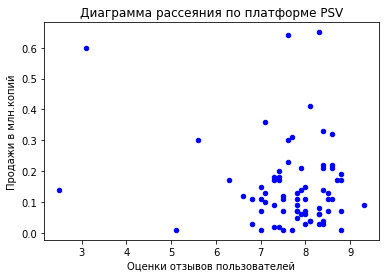

critic_score    0.042665
total_sales     1.000000
Name: total_sales, dtype: float64

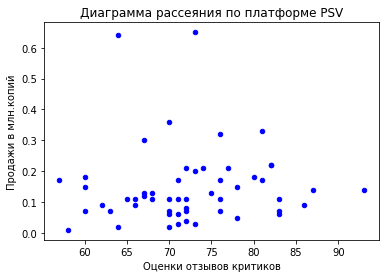

Расчет по Платформе Wii
Для платформы Wii не хватает данных для построения диаграммы и расчета корреляции отзывов пользователей
Для платформы Wii не хватает данных для построения диаграммы и расчета корреляции отзывов критиков
Расчет по Платформе WiiU


user_score     0.407926
total_sales    1.000000
Name: total_sales, dtype: float64

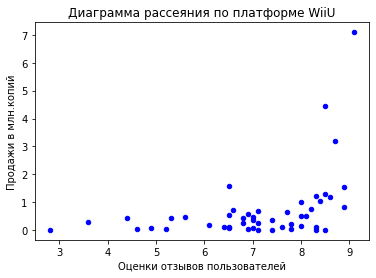

critic_score    0.370201
total_sales     1.000000
Name: total_sales, dtype: float64

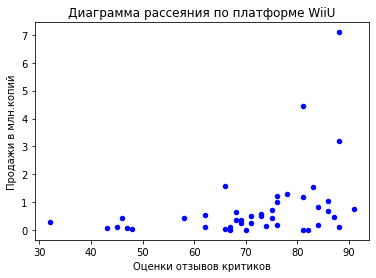

Расчет по Платформе X360


user_score    -0.138445
total_sales    1.000000
Name: total_sales, dtype: float64

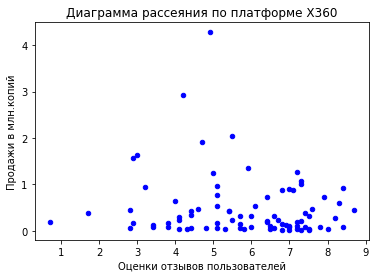

critic_score    0.525723
total_sales     1.000000
Name: total_sales, dtype: float64

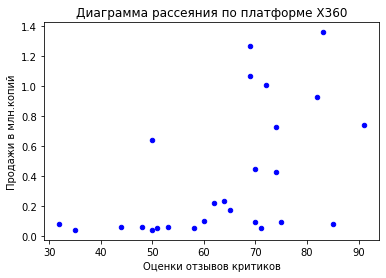

Расчет по Платформе XOne


user_score    -0.070384
total_sales    1.000000
Name: total_sales, dtype: float64

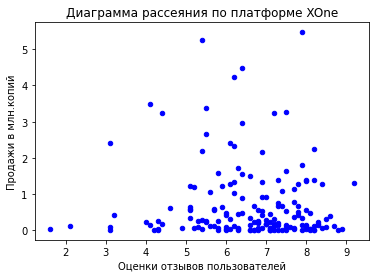

critic_score    0.428677
total_sales     1.000000
Name: total_sales, dtype: float64

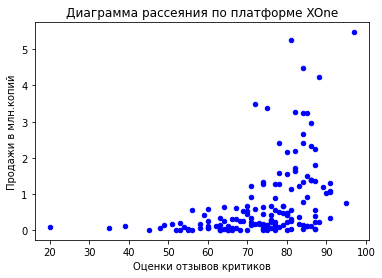

In [100]:
import matplotlib.pyplot as plt
df_sc, y = data_useful.copy(), 'total_sales'
for platform, games_on_pl in df_sc.groupby('platform'):
    print('='*60)
    print('Расчет по Платформе',platform)
    # Считаем сколько в колонке не пустых отзывов
    not_user = len(games_on_pl[(games_on_pl.user_score != -1)&(games_on_pl['user_score'].notna() == True)])
    not_critic = len(games_on_pl[(games_on_pl.critic_score != -1)&(games_on_pl['user_score'].notna() == True)])
    sum_not = 3 # Задаем количество не пустых значений для вывода диаграммы и расчета корреляции
    if not_user > sum_not:
        games_on_pl[games_on_pl.user_score != -1].plot(kind='scatter', x='user_score', y=y, color='b')
        display(games_on_pl[games_on_pl.user_score != -1][['user_score', y]].corr()[y])
        plt.xlabel('Оценки отзывов пользователей')
        plt.ylabel('Продажи в млн.копий')
        plt.title('Диаграмма рассеяния по платформе '+platform)
        plt.show()
    else:
        print('Для платформы',platform, 'не хватает данных для построения диаграммы и расчета корреляции отзывов пользователей')
    if not_critic > sum_not:
        games_on_pl[games_on_pl.critic_score != -1].plot(kind='scatter', x='critic_score', y=y, color='b')
        display(games_on_pl[games_on_pl.critic_score != -1][['critic_score', y]].corr()[y])
        plt.xlabel('Оценки отзывов критиков')
        plt.ylabel('Продажи в млн.копий')
        plt.title('Диаграмма рассеяния по платформе '+platform)
        plt.show()
    else:
        print('Для платформы',platform, 'не хватает данных для построения диаграммы и расчета корреляции отзывов критиков')

На графиках прослеживается зависимость между рейтингом критиков и наличием продаж. Так игры, имеющие рейтинг ниже 40 являются редкими и всегда имеют продажи, близкие к нулю, при достижении рейтинга 60 и выше, особенно не популярных платформах с большим количеством размещенных на них игр, прослеживается зависимость увеличесния продаж от увеличения рейтинга. Данное наблюдение подтверждается данными с расчетом коэффициента корреляции, который составляет от 0,31 до 0,52 для большинства платформ. В то же время в данных имеются 2 платформы (РС и PSV) с отсутствием взаимосвязи между отзывами и продажами и имеющие одинаковый объем продаж для игр с любыми отзывами. В данном случае отсутствие такой зависимости может быть объяснено в том числе работой самих платформ.

Зависимости между отзывами пользователей и уровнем продаж игр выявлено не было (коэффициент корреляции для большинства платформ близок к нулю и на графике так же не наблюдается зависимости). Можно лишь отметить, что в массиве данныхпрактически отсутствуют игры с рейтингом ниже 2.

В соответствии с полученными данными, зависимости между отзывами пользователей и уровнем продаж игр выявлено не было (коэффициент корреляции около нуля и на графике так же не наблючается зависимости).
Отзывы критиков влияют на продажи более заметно (коэффициент корреляции равен 0,4), на графике также наблюдается большее рассеивание, которое начинается от уровня оценки критика выше 60. Также согласно графику, можно сказать, что игры с отзывами критиков ниже 60 имеют продажи, близкие к нулю, в то время как наличие отзыва критика выше 60 дает игре возможность большего заработка.

Проверим данные выводы на продажах другими платформами.

Для платформ, выявленных как наиболее перспективные, показатели зависимости полностью совпадают.
Для платформ, выявленных как менее перспективные, зависимость от уровня отзывов пользователей увеличивается, в то время как зависимость от уровня отзывов критиков уменьшается.

Влияние на продажи отзывов критиков в разбивке по платформам


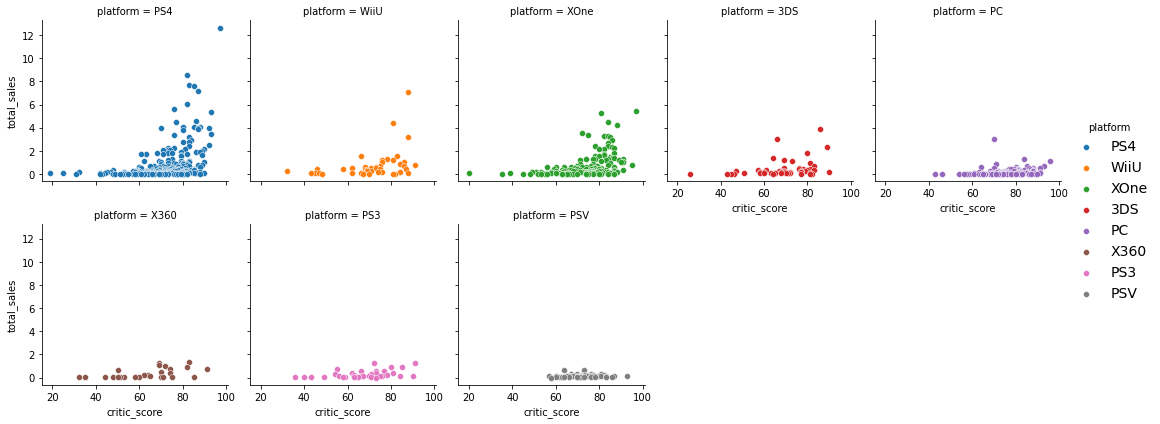

In [58]:
print ('Влияние на продажи отзывов критиков в разбивке по платформам')
critic_scores = sns.FacetGrid(data_useful_critic, col="platform", hue="platform", col_wrap=5)
critic_scores.map(sns.scatterplot, 'critic_score', 'total_sales')

critic_scores.add_legend(fontsize=14)

Влияние на продажи отзывов пользователей в разбивке по платформам


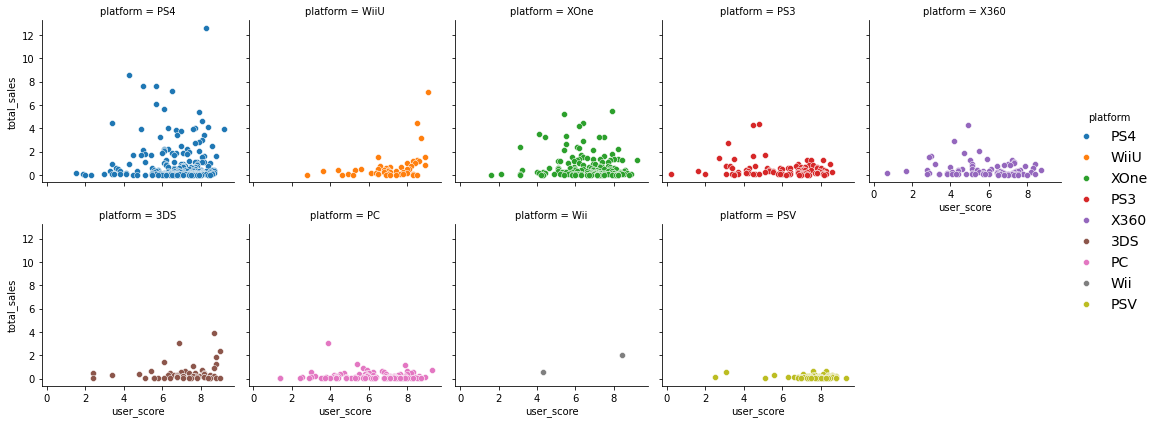

In [59]:
print ('Влияние на продажи отзывов пользователей в разбивке по платформам')
user_scores = sns.FacetGrid(data_useful_user, col="platform", hue="platform", col_wrap=5)
user_scores.map(sns.scatterplot, 'user_score', 'total_sales')

user_scores.add_legend(fontsize=14)

### Распределение игр по жанрам

Рассмотри общее распределение игр по жанрам, определив суммарный объем продаж для каждого.

In [60]:
data_ganre = (data_useful.
              pivot_table(index='genre', values='total_sales', aggfunc='median').
              sort_values(by='total_sales', ascending=False).
              reset_index()
             )
data_ganre

,genre,total_sales
0,Shooter,0.515
1,Sports,0.180
2,Platform,0.140
3,Fighting,0.125
4,Role-Playing,0.110
5,Simulation,0.100
6,Action,0.090
7,Misc,0.090
8,Racing,0.090
9,Strategy,0.060


Text(0, 0.5, 'Продажи (миллионы проданных копий)')

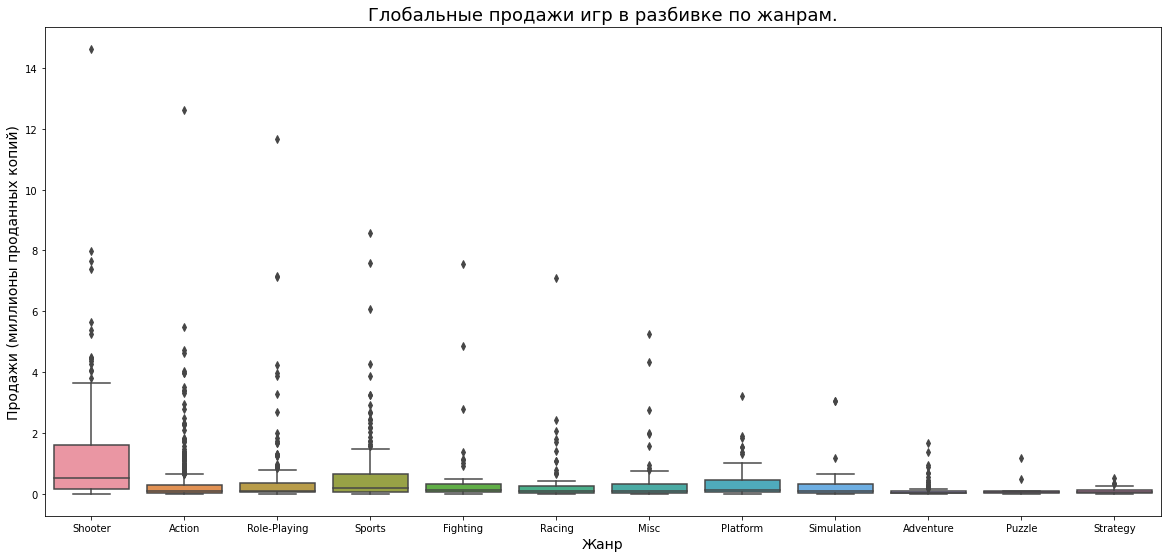

In [61]:
plt.figure(figsize=(20, 9))

sns.boxplot(x = 'genre', y = 'total_sales', data = data_useful)

plt.title('Глобальные продажи игр в разбивке по жанрам.', fontsize=18)
plt.xlabel('Жанр', fontsize=14)
plt.ylabel('Продажи (миллионы проданных копий)', fontsize=14)

Построим данный график более наглядно, без учета существенных выбросов у ряда жанров.

Text(0, 0.5, 'Продажи (миллионы проданных копий)')

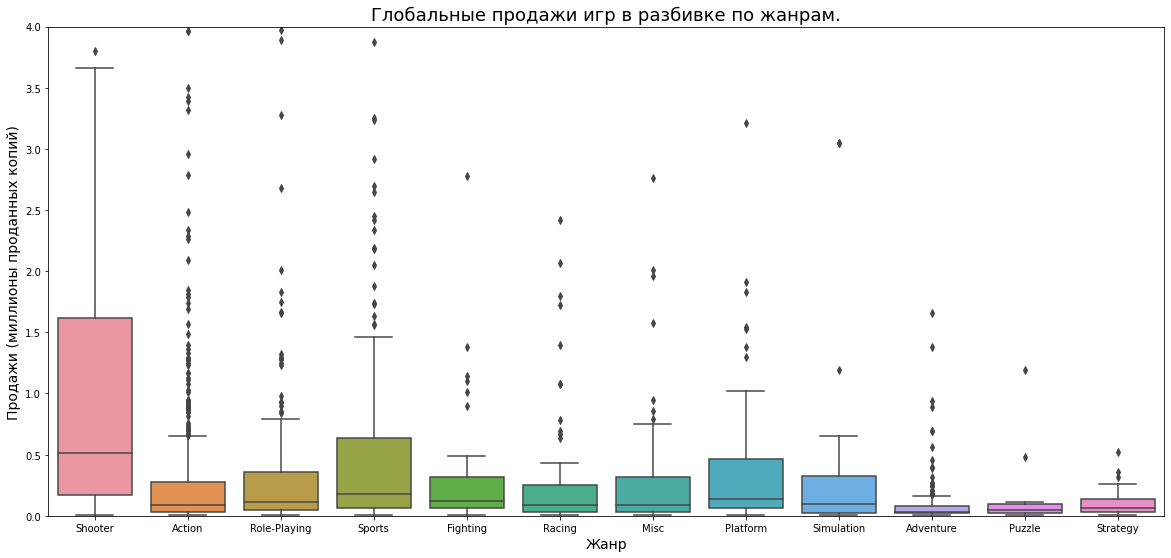

In [62]:
plt.figure(figsize=(20, 9))

sns.boxplot(x = 'genre', y = 'total_sales', data = data_useful)

plt.ylim(0, 4)
plt.title('Глобальные продажи игр в разбивке по жанрам.', fontsize=18)
plt.xlabel('Жанр', fontsize=14)
plt.ylabel('Продажи (миллионы проданных копий)', fontsize=14)

Как видно из графиков и подтверждено расчетами, наиболее популярным жанром, который в соответствии с медианой регулярно приносит прибыль, является Shooter, далее можно выделить жанры Sports и Platform. Наименее популярными являются Adventure и Puzzle.

## Портрет пользователя каждого региона.

Для создания портрета пользователя из каждого региона определим отдельно для пользователей из Европы, Северной Америки и Японии следующие характеристики:
- Самые популярные платформы (топ-5).
- Самые популярные жанры (топ-5).
- Влияние рейтинга ESRB на продажи.

### Европа

**Самые популярные платформы.**

In [63]:
data_useful_eu = (data_useful.
 pivot_table(index='platform', values='eu_sales', aggfunc='sum').
 sort_values(by='eu_sales', ascending=False).
 reset_index()
)

data_useful_eu.head()

,platform,eu_sales
0,PS4,130.04
1,XOne,46.25
2,PS3,25.54
3,PC,17.97
4,3DS,16.12


In [64]:
best_platforms_eu = data_useful_eu.loc[0:4, 'platform'].unique() # Пять наиболее успешных платформ в Европе

best_platforms_eu

array(['PS4', 'XOne', 'PS3', 'PC', '3DS'], dtype=object)

In [65]:
data_useful_eu['platform'] = data_useful_eu['platform'].where(data_useful_eu['platform'].isin(best_platforms_eu), 'другие')

data_useful_eu = data_useful_eu.groupby('platform').sum()

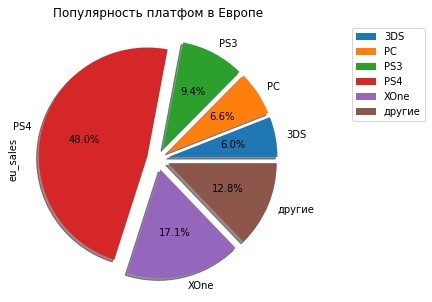

In [66]:
data_useful_eu.plot(y='eu_sales', kind='pie', figsize=(5,5), autopct='%1.1f%%', explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1), shadow=True)

plt.title('Популярность платфом в Европе')
plt.legend(bbox_to_anchor=(1.5, 1))

**Самые популярные жанры.**

In [67]:
data_useful_eu_genre = (data_useful.
 pivot_table(index='genre', values='eu_sales', aggfunc='sum').
 sort_values(by='eu_sales', ascending=False).
 reset_index()
)

data_useful_eu_genre.head()

,genre,eu_sales
0,Action,74.68
1,Shooter,65.52
2,Sports,45.73
3,Role-Playing,28.17
4,Racing,14.13


In [68]:
best_platforms_eu_genre = data_useful_eu_genre.loc[0:4, 'genre'].unique()

best_platforms_eu_genre

array(['Action', 'Shooter', 'Sports', 'Role-Playing', 'Racing'],
      dtype=object)

In [69]:
data_useful_eu_genre['genre'] = data_useful_eu_genre['genre'].where(data_useful_eu_genre['genre'].isin(best_platforms_eu_genre), 'другие')

data_useful_eu_genre = data_useful_eu_genre.groupby('genre').sum()
data_useful_eu_genre

,eu_sales
genre,
Action,74.68
Racing,14.13
Role-Playing,28.17
Shooter,65.52
Sports,45.73
другие,42.45


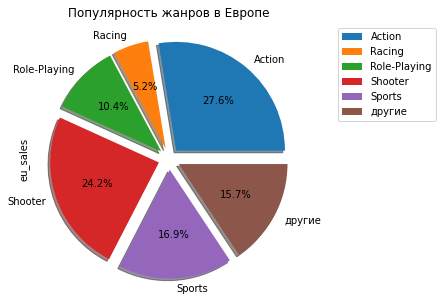

In [70]:
data_useful_eu_genre.plot(y='eu_sales', kind='pie', figsize=(5,5), autopct='%1.1f%%', explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1), shadow=True)

plt.title('Популярность жанров в Европе')
plt.legend(bbox_to_anchor=(1.5, 1))

**Влияние рейтинга ESRB на продажи.**

Для определения влияния рейтинга, уберем из мессива даных информацию, в которой отсутствуют данные о рейтинге.

In [71]:
data_useful_rating = data_useful.query('rating != "no_rating"')

Text(0, 0.5, 'Продажи в Европе')

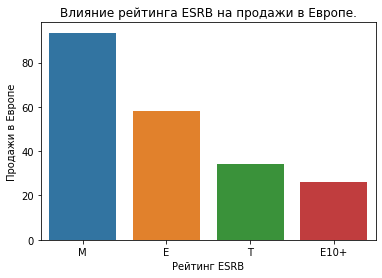

In [72]:
data_eu = data_useful_rating.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).reset_index()

diagram_eu = sns.barplot(x='rating', y='eu_sales', data=data_eu)

diagram_eu.set_title('Влияние рейтинга ESRB на продажи в Европе.')
diagram_eu.set_xlabel('Рейтинг ESRB')
diagram_eu.set_ylabel('Продажи в Европе')

Для пользователей из Европы наиболее вотребованными являлись платформы PS4 и XOne, наиболее популярные жанры игр: Action, Shooter, Sports, наиболее популярный рейтинг М (для взрослых), следующий по популярности - Е (для всех), что объясняется высокой популярность игр жанра Shooter.

### Северная Америка

**Самые популярные платформы.**

In [73]:
data_useful_na = (data_useful.
 pivot_table(index='platform', values='na_sales', aggfunc='sum').
 sort_values(by='na_sales', ascending=False).
 reset_index()
)

data_useful_na.head()

,platform,na_sales
0,PS4,98.61
1,XOne,81.27
2,X360,28.30
3,3DS,22.64
4,PS3,22.05


In [74]:
best_platforms_na = data_useful_na.loc[0:4, 'platform'].unique() # Пять наиболее успешных платформ

best_platforms_na

array(['PS4', 'XOne', 'X360', '3DS', 'PS3'], dtype=object)

In [75]:
data_useful_na['platform'] = data_useful_na['platform'].where(data_useful_na['platform'].isin(best_platforms_na), 'другие')

data_useful_na = data_useful_na.groupby('platform').sum()

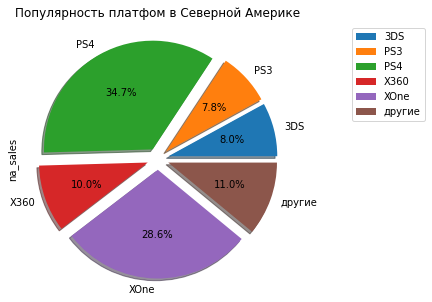

In [76]:
data_useful_na.plot(y='na_sales', kind='pie', figsize=(5,5), autopct='%1.1f%%', explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1), shadow=True)

plt.title('Популярность платфом в Северной Америке')
plt.legend(bbox_to_anchor=(1.5, 1))

**Самые популярные жанры.**

In [77]:
data_useful_na_genre = (data_useful.
 pivot_table(index='genre', values='na_sales', aggfunc='sum').
 sort_values(by='na_sales', ascending=False).
 reset_index()
)

data_useful_na_genre.head()

,genre,na_sales
0,Shooter,79.02
1,Action,72.53
2,Sports,46.13
3,Role-Playing,33.47
4,Misc,15.05


In [78]:
best_platforms_na_genre = data_useful_na_genre.loc[0:4, 'genre'].unique()

best_platforms_na_genre

array(['Shooter', 'Action', 'Sports', 'Role-Playing', 'Misc'],
      dtype=object)

In [79]:
data_useful_na_genre['genre'] = data_useful_na_genre['genre'].where(data_useful_na_genre['genre'].isin(best_platforms_na_genre), 'другие')

data_useful_na_genre = data_useful_na_genre.groupby('genre').sum()
data_useful_na_genre

,na_sales
genre,
Action,72.53
Misc,15.05
Role-Playing,33.47
Shooter,79.02
Sports,46.13
другие,37.86


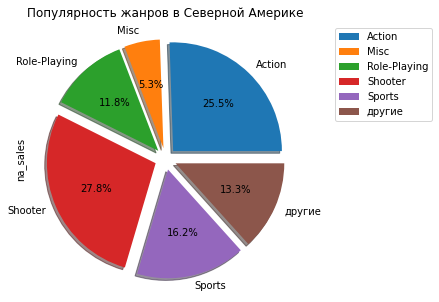

In [80]:
data_useful_na_genre.plot(y='na_sales', kind='pie', figsize=(5,5), autopct='%1.1f%%', explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1), shadow=True)

plt.title('Популярность жанров в Северной Америке')
plt.legend(bbox_to_anchor=(1.5, 1))

**Влияние рейтинга ESRB на продажи.**

In [2]:
data_na = data_useful_rating.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).reset_index()

diagram_na = sns.barplot(x='rating', y='na_sales', data=data_na)

diagram_eu.set_title('Влияние рейтинга ESRB на продажи в Северной Америке.')
diagram_eu.set_xlabel('Рейтинг ESRB')
diagram_eu.set_ylabel('Продажи в Северной Америке')

NameError: name 'data_useful_rating' is not defined

Для пользователей из Северной Америки наиболее вотребованными являлись платформы  PS4 и XOne (аналогично Европе), наиболее популярные жанры игр Shooter, Action, Sports (наиболее популярный жанр совпадает с наиболее популярным жанров в Европе), наиболее популярный рейтинг М (для взрослых), следующий по популярности - Е (для всех), что объясняется высокой популярность игр жанра Shooter. Данная характеристика совпадает с европейскими тенденциями.

### Япония

**Самые популярные платформы.**

In [82]:
data_useful_jp = (data_useful.
 pivot_table(index='platform', values='jp_sales', aggfunc='sum').
 sort_values(by='jp_sales', ascending=False).
 reset_index()
)

data_useful_jp.head()

,platform,jp_sales
0,3DS,44.24
1,PS4,15.02
2,PSV,14.54
3,PS3,11.22
4,WiiU,7.31


In [83]:
best_platforms_jp = data_useful_jp.loc[0:4, 'platform'].unique() # Пять наиболее успешных платформ

best_platforms_jp

array(['3DS', 'PS4', 'PSV', 'PS3', 'WiiU'], dtype=object)

In [84]:
data_useful_jp['platform'] = data_useful_jp['platform'].where(data_useful_jp['platform'].isin(best_platforms_jp), 'другие')

data_useful_jp = data_useful_jp.groupby('platform').sum()

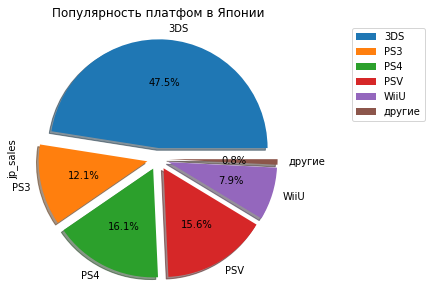

In [85]:
data_useful_jp.plot(y='jp_sales', kind='pie', figsize=(5,5), autopct='%1.1f%%', explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1), shadow=True)

plt.title('Популярность платфом в Японии')
plt.legend(bbox_to_anchor=(1.5, 1))

**Самые популярные жанры.**

In [86]:
data_useful_jp_genre = (data_useful.
 pivot_table(index='genre', values='jp_sales', aggfunc='sum').
 sort_values(by='jp_sales', ascending=False).
 reset_index()
)

data_useful_jp_genre.head()

,genre,jp_sales
0,Role-Playing,31.16
1,Action,29.58
2,Fighting,6.37
3,Misc,5.61
4,Shooter,4.87


In [87]:
best_platforms_jp_genre = data_useful_jp_genre.loc[0:4, 'genre'].unique()

best_platforms_jp_genre

array(['Role-Playing', 'Action', 'Fighting', 'Misc', 'Shooter'],
      dtype=object)

In [88]:
data_useful_jp_genre['genre'] = data_useful_jp_genre['genre'].where(data_useful_jp_genre['genre'].isin(best_platforms_jp_genre), 'другие')

data_useful_jp_genre = data_useful_jp_genre.groupby('genre').sum()
data_useful_jp_genre

,jp_sales
genre,
Action,29.58
Fighting,6.37
Misc,5.61
Role-Playing,31.16
Shooter,4.87
другие,15.50


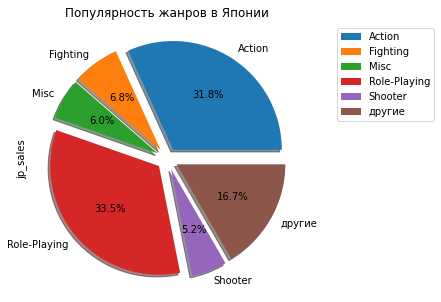

In [89]:
data_useful_jp_genre.plot(y='jp_sales', kind='pie', figsize=(5,5), autopct='%1.1f%%', explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1), shadow=True)

plt.title('Популярность жанров в Японии')
plt.legend(bbox_to_anchor=(1.5, 1))

**Влияние рейтинга ESRB на продажи.**

Text(0, 0.5, 'Продажи в Японии')

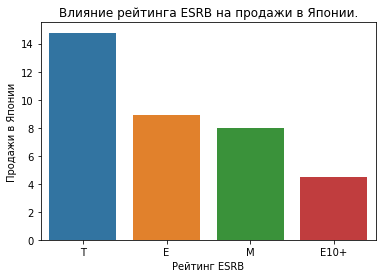

In [90]:
data_jp = data_useful_rating.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).reset_index()

diagram_jp = sns.barplot(x='rating', y='jp_sales', data=data_jp)

diagram_jp.set_title('Влияние рейтинга ESRB на продажи в Японии.')
diagram_jp.set_xlabel('Рейтинг ESRB')
diagram_jp.set_ylabel('Продажи в Японии')

Для пользователей из Японии наиболее вотребованными являлись платформы  3DS и PS4 , наиболее популярные жанры игр: Action, Role-Playing, наиболее популярный рейтинг T (для подростков), следующий по популярности - Е (для всех). Данные показатели значительно отличаются от европейских или североамериканских.

Данное исследование показало влияние культурных аспектов на предпочтения пользователей. Основные потребители игр в Японии - тинейджеры, в то время, как для Европы и Северной Америки, имеющих схожую культурную составляющую, более популярны игры для взрослых. Данный аспект оказывает непосредственное влияние на разные предпочтения в жанрах и платформах. 

## Проверка гипотез.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Гипотеза:

- Нулевая - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые (определяем нулевую гипотезу исходя из первого предположения, что данные платформы действительно очень известны и конкурентны между собой, в связи с чем могут иметь одинаковые рейтинги). 
- Альтернативная - Средние пользовательские рейтинги платформ Xbox One разные (определяем альтернативную гипотезу как двустороннюю).

Выберем статистический уровень значимости 5%, как наиболее часто принятый.

In [91]:
alpha = 0.05

In [92]:
data_xone = data_useful.query('(platform == "XOne") & (user_score >= 0)')
data_pc = data_useful.query('(platform == "PC") & (user_score >= 0)')

In [93]:
result1 = st.ttest_ind(data_xone['user_score'], data_pc['user_score'])

if result1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отверкнуть нулевую гипотезу')

Не получилось отверкнуть нулевую гипотезу


Проверим данную гипотезу дополнительным рассчетом среднего значания рейтинга для каждой из групп:

In [94]:
data_xone['user_score'].mean()

6.594545454545456

In [95]:
data_pc['user_score'].mean()

6.298360655737705

Согласно проведенной проверке гипотезы, средние пользовательские рейтинги платформ Xbox One и PC одинаковые, определяем нулевую гипотезу как верную. При проведении дополнительного расчета средних для каждой группы было выявлено, что средние рейтинги данных платформ отличаются незначительно и при тестировании оказалось больше статистического уровня значимости, поставленная нулевая гипотеза не может быть отвергнута.

### Средние пользовательские рейтинги жанров Action и Sports разные.

Гипотеза:

- Нулевая - Средние пользовательские рейтинги жанров Action и Sports одинаковые (определяем нулевую гипотезу исходя из постановки задачи, нам нужно выяснить одинаковые ли рейтинги жанров или разные).
- Альтернативная - Средние пользовательские рейтинги жанров Action и Sports не одинаковые (определяем альтернативную гипотезу исходя из постановки задачи, нам не важно какой из жанров имеет более высокий рейтинг, поэтому гипотеза будет двусторонней).

Статистический уровень значимости оставляем принятым ранее (5%).

In [96]:
data_action = data_useful.query('(genre == "Action") & (user_score >= 0)')
data_sports = data_useful.query('(genre == "Sports") & (user_score >= 0)')

In [97]:
result2 = st.ttest_ind(data_action['user_score'], data_sports['user_score'])

if result2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отверкнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


Проверим данную гипотезу дополнительным рассчетом среднего значания рейтинга для каждой из групп:

In [98]:
data_action['user_score'].mean()

6.760606060606061

In [99]:
data_sports['user_score'].mean()

5.2251968503937

Согласно проведенной проверке гипотезы, пользовательские рейтинги жанров Action и Sports разные. Данное заключение было так же проверено сравнением средних значений рейтингов для каждого жанра, которые значительно отличаются друг от друга, в связи с чем нулевая гипотеза отвергается.

**Пояснения по разделу.**

В ходе постановки и рассмотрения данных двух гипотез были сформулированы и поставлены нулевые и двусторонние альтернативные гипотезы в обоих случаях. Нулевая гипотеза была определена исходя из первого предположения в соответствии с заданием к проекту, выбор двусторонних альтернативных гипотез объясняется отсутствием конкретной задачи определить среднее какой выборки больше или меньше, достаточно понимание их равенства или различия в соответствии с уровнем статистической значимости (пороговое значение, начиная с которого наблюдаемое значение будет считается слишком далёким от предполагаемого и маловероятным). Статистическим уровнем значимости был принят 5%, как как общепринятое пороговое значение.

Общепринятым инструментом для проверки гипотез является t-тест, который и был выбран для проверки. Он также позволяет рассматривать двусторонние варианты гипотез и работать с выборками как маленького (для каких он и был создан), так и большого размера, в связи с чем при проведении этого теста не было нобходимости оценивать каждую из четырех выборок данных тестов на количество элементов в них с целью оценки корректности тестирования. В связи с чет данный тест является наиболее удобным.




# **<font color='green'>ОБЩИЙ ВЫВОД ПО ПРОЕКТУ.</font>**

Данный проект был направлен на проведение анализа для интернет-магазина компьютерных игр на основе открытых источников исторических данных с целью выявления определяющих успешность игры закономерностей. Массив данных, используемый для проведения исследования, содержал информацию о: названиях игр, платформах, годах выпуска, жанрах, продажах в Северной Америке, Европе, Японии и в других странах, оценки критиков, оценки пользователей, а также рейтинг от организации ESRB.

На первом шаге работы была проведена **предобработка данных**, включающая: предварительный анализ основной информации о базе данных (в том числе ее соответствие требуемому типу данных), проверка массива на наличие пропусков и заполнение их удобными для отсортировки вариантами, проверка данных на наличие дубликатов и удаление найденных. В ходе данного этапа, все данные были приведены к необходимой форме, а также добавлен дополнительный столбец total_sales, содержащий суммарное количество проданных копий по всем регионам.


Далее был проведен **исследовательский анализ данных**, в ходе которого были проанализированы следующие показатели и сделаны соответствующие выводы:
1. Количество игр, выпускаемых ежегодно. Согласно полученному расчету, первые игры, учтенные в имеющемся массиве данных, были созданы в 1980, но количество выпускаемых игр было незначительно до 1993 года, после чего наблюдался значительный рост количества, создаваемого ежегодно. Максимальное количество игр было выпущено в 2008 и 2009 годах, после чего интенсивность данного процесса пошла на спад.  Наибольшее количество выпущенных игр было создано в период с 2003 до 2010 года.

2. Продажи по платформам. Срок существования платформ обычно составляет 7 лет с выраженным периодом максимальной активности. Все платформы, выявленные как наиболее успешные в соответствии с наибольшим количеством продаж, завершили свой срок жизни и исчезли или практически исчезли к 2016 году. Ни одна платформа, находящаяся в 2016 году в стадии роста или пика не была определена как успешная ввиду меньших объемов продаж, что подтверждает общую тенденцию спада рынка. В ходе исследования было определено две платформы, находящиеся в стадии развития, которые могут быть определены как перспективные: PS4, XOne.

3. Глобальные продажи игр в разбивке по платформам. Каждая платформа имела единичные достаточно успешные игры, но продажи основного объема игр не превышало 0,25 млн проданных копий для каждой платформы. Выявленные платформы, имеющие наибольшее медианное значение продаж, приближающееся к 0,25 млн копий: PS4, XOne, WiiU, X360, Wii. 

4. Влияние на продажи отзывов пользователей и критиков. В ходе исследования было выявлено, что отзывы критиков заметно влияют на продажи на большинстве платформ. Согласно исследованию, можно сказать, что игры с отзывами критиков ниже 60 имеют продажи, близкие к нулю, в то время как наличие отзыва критика выше 60 дает игре возможность большего заработка. В то же время, были обнаружены платформы, не имеющие такой зависимости, что может быть связано с непопулярностью платформы или другими зависимостями от ее работы. Отзывы пользователей не оказывают столь значительного влияния. В ходе проведения исследования зависимости выявлены не были. 

5. Распределение игр по жанрам. В зависимости от медианы по продажам удалось выделить популярные и непопулярные жанры. Так, наиболее популярным является жанр Shooter, далее можно выделить жанры Sports и Platform. Наименее популярными являются Adventure и Puzzle.

В ходе дальнейшего проведения проекта были определены **портреты пользователей каждого региона**. Для создания портрета пользователя из каждого региона были определены отдельно для пользователей из Европы, Северной Америки и Японии самые популярные платформы (топ-5), самые популярные жанры (топ-5), влияние рейтинга ESRB на продажи. Данное исследование показало влияние культурных аспектов на предпочтения пользователей. Основные потребители игр в Японии - тинейджеры, в то время, как для Европы и Северной Америки, имеющих схожую культурную составляющую между собой, более популярны игры для взрослых. Данный аспект оказывает непосредственное влияние на разные предпочтения в жанрах и платформах. 

В завершении проекта была проведена **проверка двух гипотез**:
1.	Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Согласно проведенной проверке гипотезы, средние пользовательские рейтинги платформ Xbox One и PC одинаковы, что было так же подтверждено сравнением средних значений рейтингов для каждой из платформ, в связи с чем нулевая гипотеза не была отвергнута. 
2.	Средние пользовательские рейтинги жанров Action и Sports одинаковые. Согласно проведенной проверке гипотезы, пользовательские рейтинги жанров Action и Sports разные. Данное заключение было так же проверено сравнением средних значений рейтингов для каждого жанра, которые значительно отличаются друг от друга, в связи с чем нулевая гипотеза была отвергнута. 

**<font color='red'>Рекомендации.</font>**
Таким образом в результате данного исследования были выявлены важные тенденции, которые могут быть использованы при планировании рекламных кампаний и определении потенциально популярного продукта. 
- В первую очередь необходимо учитывать общий спад рынка игр. Наиболее перспективными платформами в данный момент являются PS4 и XOne, которые в 2016 году сохраняли высокий уровень продаж несмотря на негативные тенденции рынка.  
- Выбор жанра перспективного продукта зависит от предполагаемого рынка продаж, поскольку потребители в Азии и Европе имеют значительно отличающиеся предпочтения. Action популярен во всех регионах, но потребители в Европе и Северной Америке так же предпочитают Shooter.
- Отзывы критиков важны для продвижения не на всех платфомах. Для обозначенных платформ PS4 и XOne они имеют значение. Отзывы пользователей не оказывают какого-либо влияния на продажи, в связи с чем их учет необязателен.
- Рейтингом ESRB также как и жанр игр важен при рассмотрении продаж в разрезе по регионам. Основные потребители в Японии - тинейджеры, а в Европе и Северной Америке - взрослые.  